In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from gzreduction.vote_sources.panoptes_exports import export_to_responses
from gzreduction.vote_sources.panoptes_exports import aggregate
from gzreduction.schemas.euclid_schema import euclid_schema

In [3]:
import niceplots

niceplots.initPlot()


In [4]:

schema = euclid_schema
# schema = euclid_ortho_schema

In [5]:
date_str = '2024_12_23'

In [6]:
# classification_export_loc = '/home/walml/repos/gz-panoptes-reduction/data/euclid/euclid-development-classifications_' + date_str + '.csv'
# aggregated_loc = '/home/walml/repos/gz-panoptes-reduction/data/euclid/euclid_development_reduced_votes_' + date_str + '.csv'

classification_export_loc = '/home/walml/repos/gz-panoptes-reduction/data/euclid/euclid-challenge-classifications_' + date_str + '.csv'
aggregated_loc = '/home/walml/repos/gz-panoptes-reduction/data/euclid/euclid_challenge_reduced_votes_' + date_str + '.csv'

In [7]:
# nrows = 10000
nrows = None
clf = pd.read_csv(classification_export_loc, nrows=nrows)
clf

,classification_id,user_name,user_id,user_ip,workflow_id,workflow_name,workflow_version,created_at,gold_standard,expert,metadata,annotations,subject_data,subject_ids
0,575637319,MikeWalmsley,290475.0,bbb67ee45e8488ce3b76,27100,Euclid Challenge,1.1,2024-08-01 12:31:20 UTC,NaN,NaN,"{""source"":""api"",""session"":""bb29dd0cbc265ed2c59...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101103135"":{""retired"":{""id"":131273171,""workf...",101103135
1,575637443,MikeWalmsley,290475.0,bbb67ee45e8488ce3b76,27100,Euclid Challenge,1.1,2024-08-01 12:33:05 UTC,NaN,NaN,"{""source"":""api"",""session"":""bb29dd0cbc265ed2c59...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101101075"":{""retired"":{""id"":131273208,""workf...",101101075
2,575637955,unravel,2403423.0,240f74cca0be2ade255e,27100,Euclid Challenge,1.1,2024-08-01 12:38:36 UTC,NaN,NaN,"{""source"":""api"",""session"":""6b06594340d3b205cdd...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101093977"":{""retired"":{""id"":131273284,""workf...",101093977
3,575638057,unravel,2403423.0,240f74cca0be2ade255e,27100,Euclid Challenge,1.1,2024-08-01 12:39:45 UTC,NaN,NaN,"{""source"":""api"",""session"":""6b06594340d3b205cdd...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101091891"":{""retired"":{""id"":131273307,""workf...",101091891
4,575640326,not-logged-in-1bfeecaa6f2a414c06de,NaN,1bfeecaa6f2a414c06de,27100,Euclid Challenge,1.1,2024-08-01 12:55:02 UTC,NaN,NaN,"{""source"":""api"",""session"":""399725f27fd2dd1f611...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101086153"":{""retired"":{""id"":131273544,""workf...",101086153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835085,606747014,pkp_1232001,927901.0,1aaa0e89ca01f85897c1,27100,Euclid Challenge,1.1,2024-12-21 01:30:09 UTC,NaN,NaN,"{""source"":""api"",""session"":""f84e1ce98e08966d440...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101721378"":{""retired"":null,""!filename"":""ff4e...",101721378
835086,606747229,pkp_1232001,927901.0,80e256f8a85f4f6eb81e,27100,Euclid Challenge,1.1,2024-12-21 01:32:06 UTC,NaN,NaN,"{""source"":""api"",""session"":""f84e1ce98e08966d440...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101721273"":{""retired"":null,""!filename"":""e3e5...",101721273
835087,606747286,pkp_1232001,927901.0,80e256f8a85f4f6eb81e,27100,Euclid Challenge,1.1,2024-12-21 01:32:34 UTC,NaN,NaN,"{""source"":""api"",""session"":""f84e1ce98e08966d440...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101735855"":{""retired"":null,""!filename"":""940e...",101735855
835088,606747457,pkp_1232001,927901.0,80e256f8a85f4f6eb81e,27100,Euclid Challenge,1.1,2024-12-21 01:33:52 UTC,NaN,NaN,"{""source"":""api"",""session"":""f84e1ce98e08966d440...","[{""task"":""T0"",""task_label"":""Is the galaxy simp...","{""101741965"":{""retired"":null,""!filename"":""9042...",101741965


In [8]:
len(clf['user_ip'].unique())

4174

In [9]:
len(clf['user_name'].unique())

12553

In [10]:
counts_per = clf['user_name'].value_counts()[:40]

(0.0, 12552.0)

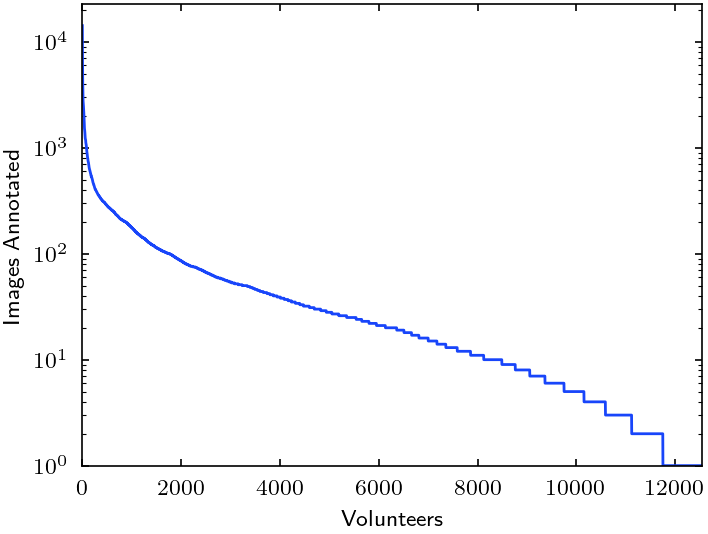

In [11]:

plt.plot(clf['user_name'].value_counts().sort_values(ascending=False).values)
plt.yscale('log')
plt.xlabel('Volunteers')
plt.ylabel('Images Annotated')
plt.ylim(1, None)
plt.xlim([0., None])

In [12]:


# pareto(1.1).pdf(0.95)


In [13]:
# clf['user_name'].value_counts()

In [14]:
y = clf['user_name'].value_counts().sort_values(ascending=False).cumsum().values
y_inv = y.max() - y
y_small = y_inv / y_inv.max()

x = 1+np.arange(len(y))
# x_small = x 

def pareto(x, b, location=0, scale=1):
    return b * scale**b / (x + location)**(b+1)

from scipy.optimize import minimize

func = lambda x0: np.sum((pareto(x, *x0) - y_small)**2)
x0 = [1.1, 0, 1]

res = minimize(func, x0)

res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 3.0463540178593718
        x: [ 3.560e+00  7.980e+03  6.458e+04]
      nit: 95
      jac: [-1.647e-04  6.703e-05  0.000e+00]
 hess_inv: [[ 3.885e-02 -7.768e-04 -1.619e+03]
            [-7.768e-04  1.558e-03  3.320e+01]
            [-1.619e+03  3.320e+01  6.772e+07]]
     nfev: 791
     njev: 195

3.56


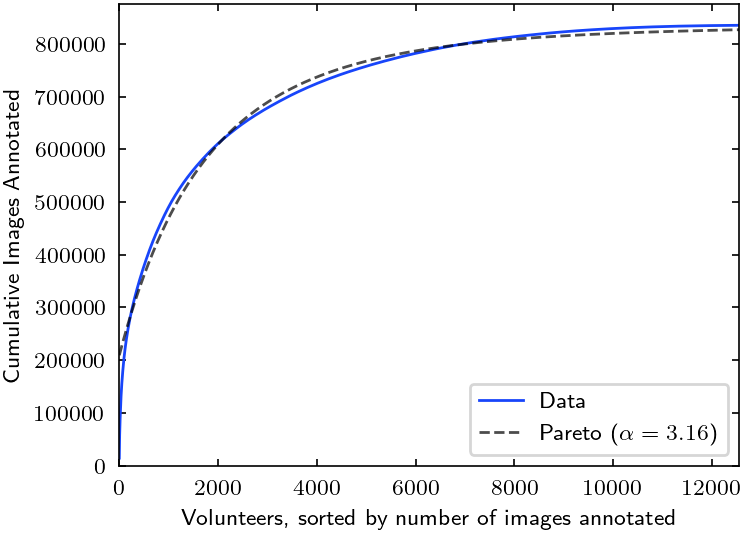

In [15]:
y_small_hat = pareto(x, *res.x)
# plt.plot(x_small, y_small, label='Data')
# plt.plot(x_small, y_small_hat, label='Pareto Fit')

plt.plot(x, y, label='Data')
b_str = '{:.2f}'.format(res.x[0])
print(b_str)
plt.plot(x, y.max() - (y_small_hat * y_inv.max()), label='Pareto (' + r'$\alpha=3.16$' + ')', color='k', linestyle='--', alpha=.7)


plt.legend(loc='lower right')
plt.xlabel('Volunteers, sorted by number of images annotated')
plt.ylabel('Cumulative Images Annotated')
plt.xlim([0., None])
plt.ylim([0., None])
plt.savefig('pareto.pdf', dpi=300, bbox_inches='tight')

In [16]:


# # def custom_optimizer(func, x0, args=(), disp=0):



# #     if res.success:

# #         return res.x

# #     raise RuntimeError('optimization routine failed')

# # a1, b1, loc1, scale1 = beta.fit(x, method="MLE", optimizer=custom_optimizer)
# from scipy.stats import pareto

# b, location, scale = pareto.fit(y_inv/y_inv.max(), floc=0, fscale=1)
# print(b, location, scale)
# # y_hat = pareto.pdf(x, b, location, scale)
# y_hat = pareto.pdf(x, b)
# plt.plot(x, y_inv)
# plt.plot(x, y_hat)

In [17]:

# x = np.linspace(1, 10, num=1000)  # x must always be 1 to N, and N should be small
# plt.plot(x, pareto(b=1, scale=1, loc=0).pdf(x))

# # pareto.pdf(y, b) / scale with y = (x - loc) / scale

(0.0, 12552.0)

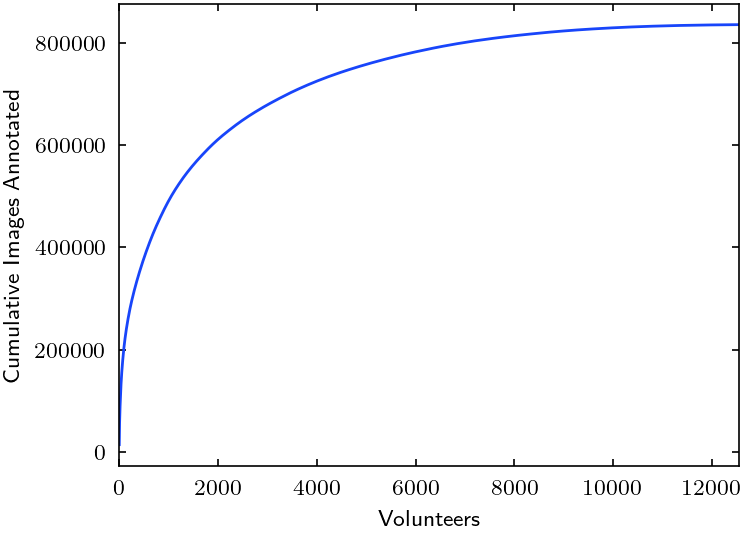

In [18]:

plt.plot(clf['user_name'].value_counts().sort_values(ascending=False).cumsum().values)
# plt.yscale('log')
plt.xlabel('Volunteers')
plt.ylabel('Cumulative Images Annotated')
plt.xlim([0., None])

In [19]:
expert_usernames = [
    'lauraleuzzi',
    'solfra',
    'Clarkguilty',
    'giulsp',
    'cmk24',
    'mhuertascompany',
    'gstevens',
    'marleau',
    'Berta_MB',
    'susan pyne',
    'helenecourtois',
    'gracca',
    'juliekatona',
    'MinaEnceladus',
    'LauraBisigello',
    'OliverMueller',
    'ThaiTran',
    'irisso',
    'antoniolamarca',
    'MikeWalmsley'
]
expert_usernames = [x.lower() for x in expert_usernames]
clf['expert'] = clf['user_name'].str.lower().isin(expert_usernames)
# clf['expert'].value_counts()
clf.query('expert').groupby('user_name')['classification_id'].count().sort_values(ascending=False)

user_name
solfra             406
ThaiTran           233
MinaEnceladus      192
antoniolamarca      86
mhuertascompany     59
OliverMueller       51
juliekatona         47
giulsp              32
helenecourtois      28
MikeWalmsley        20
irisso              12
lauraleuzzi         10
marleau             10
Berta_MB             6
cmk24                4
gstevens             3
clarkguilty          1
Name: classification_id, dtype: int64

Text(0, 0.5, 'Cum. votes by those astronomers')

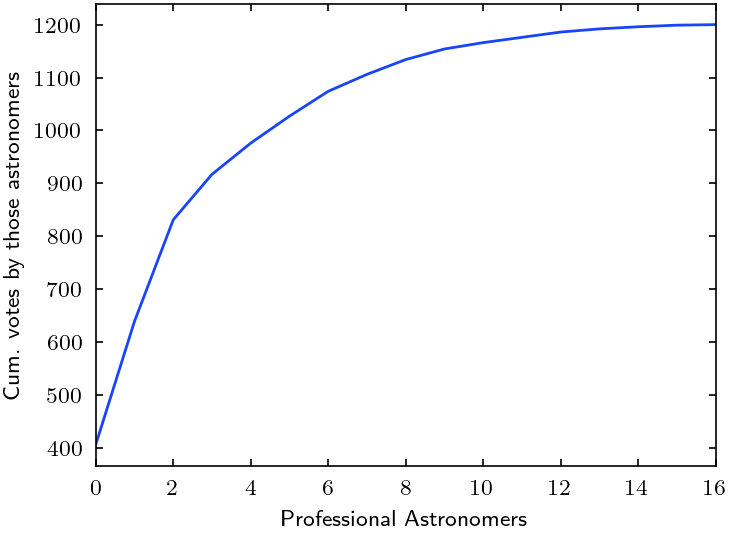

In [20]:
import matplotlib.pyplot as plt
plt.plot(clf.query('expert')['user_name'].value_counts().sort_values(ascending=False).cumsum().values)
# plt.yscale('log')
plt.xlabel('Professional Astronomers')
plt.ylabel('Cum. votes by those astronomers')
# pretty similar, maybe less extreme low count tail

In [21]:
def get_euclid_subject_id(subject_data):
    loaded = json.loads(subject_data)
    inner_dict = loaded[list(loaded.keys())[0]]
    # return inner_dict['Filename']
    return inner_dict['!filename']

In [22]:
clf['id_str'] = clf['subject_data'].apply(get_euclid_subject_id)
clf['id_str'] 

0         bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...
1         98fe3b6effab15604e484d80ef47bb7a6cb310a2c12e11...
2         18b6d8c9f5df1c44366b2a3b5ff0b1d9b3e986dd01fb73...
3         7e9871caaeccc9e709002b24f8ff097cb47516de27f609...
4         c52a8096a07e5a8af5339408267172ebcab0041a802d28...
                                ...                        
835085    ff4ef614a0916eb5cb6e8eb2018b40c5d52363b1c47b18...
835086    e3e5d1084a84ff3cfb9ab51ae71d86dbec3e59dcd6f60f...
835087    940e91343338bc2e71a2f19f397c548abb43d6bde99f46...
835088    9042f932c780da85e1f67a14f22eb14da71f877743e934...
835089    4b92d68be223794e05ec469830245d78efe6d180987511...
Name: id_str, Length: 835090, dtype: object

In [23]:
clf.columns.values

array(['classification_id', 'user_name', 'user_id', 'user_ip',
       'workflow_id', 'workflow_name', 'workflow_version', 'created_at',
       'gold_standard', 'expert', 'metadata', 'annotations',
       'subject_data', 'subject_ids', 'id_str'], dtype=object)

In [24]:
len(clf)

835090

In [25]:
# workflows = [26524]
workflows = [27100]
clf = clf[clf['workflow_id'].isin(workflows)]
assert len(clf) > 0

In [26]:
clf['created_at'] = pd.to_datetime(clf['created_at'])

In [27]:
clf_dt = clf.pivot_table(index='created_at', columns='workflow_id', values='id_str', aggfunc='count', fill_value=0)

In [28]:

clf_dt_r = clf_dt.resample('2H').sum()[27100]
clf_dt_r

created_at
2024-08-01 12:00:00+00:00     324
2024-08-01 14:00:00+00:00    3217
2024-08-01 16:00:00+00:00    3248
2024-08-01 18:00:00+00:00    3201
2024-08-01 20:00:00+00:00    3193
                             ... 
2024-12-20 16:00:00+00:00     214
2024-12-20 18:00:00+00:00     118
2024-12-20 20:00:00+00:00     247
2024-12-20 22:00:00+00:00     143
2024-12-21 00:00:00+00:00      52
Freq: 2H, Name: 27100, Length: 1699, dtype: int64

In [29]:
clf['created_at'].max() - clf['created_at'].min()

Timedelta('141 days 13:05:06')

(0.0, 24580.0)

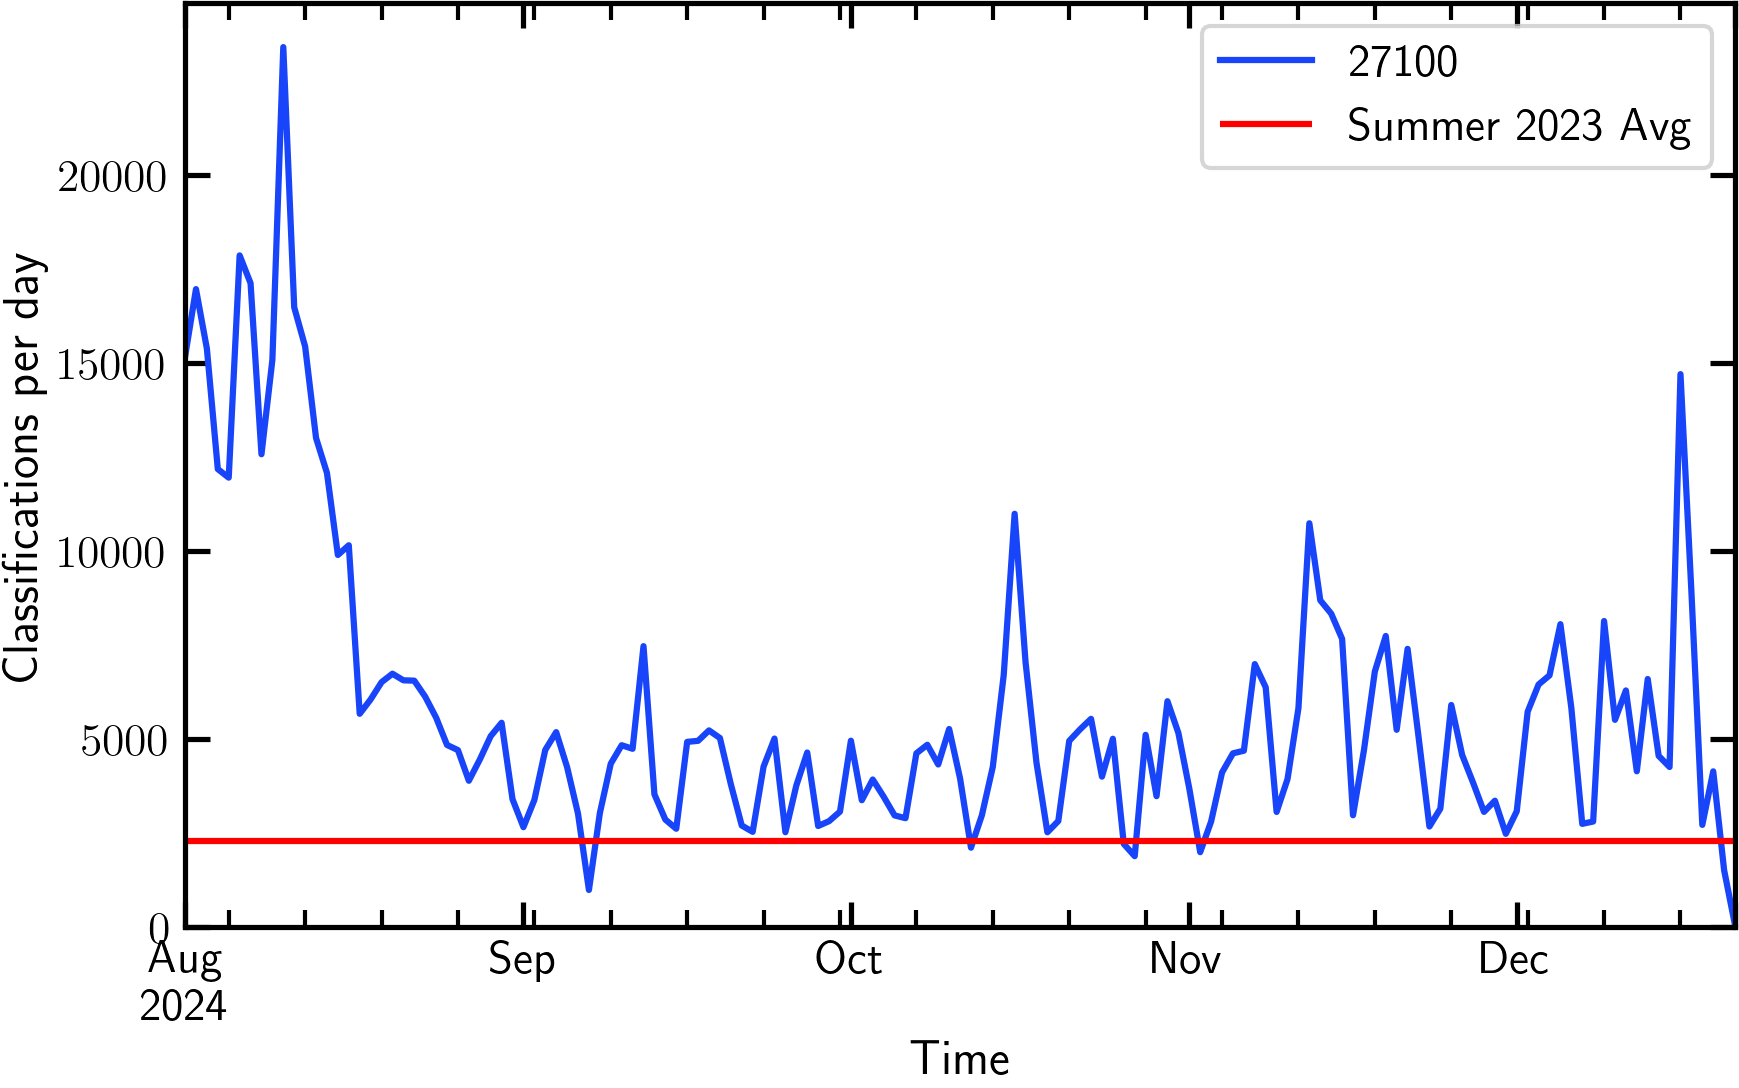

In [30]:
import seaborn as sns
sns.set_context('talk')
clf_dt_r = clf_dt.resample('1D').sum().plot(figsize=(10, 6))
# plt.plot(clf_dt_r.index, clf_dt_r.values)
plt.xlabel('Time')
plt.ylabel('Classifications per day')
# 744 hours in august
# plt.hlines(y=150000/(31*24), xmin=clf['created_at'].min(),xmax=clf['created_at'].max(), color='g', label='Aug 2022 Avg')
# plt.hlines(y=71000/(31*24), xmin=clf['created_at'].min(),xmax=clf['created_at'].max(), color='r', label='Aug 2023 Avg')
# plt.hlines(y=670, xmin=clf['created_at'].min(),xmax=clf['created_at'].max(), color='k', linestyle='--', label='Euclid Avg')
# plt.hlines(y=670, xmin=clf['created_at'].min(),xmax=clf['created_at'].max(), color='k', linestyle='--', label='Euclid Late Avg')
# plt.legend('',frameon=False)

# plt.axvline(pd.to_datetime('2024-08-01 13:00:00'), color='r', linestyle='--')
# plt.axvline(pd.to_datetime('2024-08-01 19:00:00'), color='r', linestyle='--')
plt.hlines(y=2300, xmin=clf['created_at'].min(),xmax=clf['created_at'].max(), color='r', label='Summer 2023 Avg')
plt.legend()
plt.ylim([0, None])

In [31]:
len(clf)/(7*24)

4970.773809523809

In [32]:
# clf['time_since_start'] = clf['created_at'] - clf['created_at'].min()

In [33]:
# clf['days_since_start'] = np.around(clf['time_since_start'].dt.total_seconds() / (24*3600), 1)

In [34]:
# clf_grouped = clf.groupby('days_since_start').agg({'user_name': 'count'}).reset_index()

In [35]:
clf['annotations'] = clf['annotations'].apply(json.loads)

In [36]:
# df = export_to_responses.explode_annotations(clf, exclude_tasks=['T10'])
# df

In [37]:
# plt.hist(clf['annotations'].apply(len))
clf['annotations'].isna().sum()

0

In [38]:
clf['annotations'].iloc[0]

[{'task': 'T0',
  'task_label': 'Is the galaxy simply smooth and rounded, with no sign of a disk?',
  'value': '![features_or_disk_new.png](https://panoptes-uploads.zooniverse.org/production/project_attached_image/1ec52a74-9e49-4579-91ff-0140eb5371e6.png =60x) Features or Disk'},
 {'task': 'T2',
  'task_label': 'Could this be a disk viewed edge-on?',
  'value': '![feature_or_disk.png](https://panoptes-uploads.zooniverse.org/production/project_attached_image/f353f2f1-a47e-439d-b9ca-020199162a79.png =60x) No - Something Else'},
 {'task': 'T4',
  'task_label': 'Is there a bar feature through the centre of the galaxy?',
  'value': '![bar_strong_sidebyside_acwacw_200x100.png](https://panoptes-uploads.zooniverse.org/production/project_attached_image/4b9b5758-ca37-47bd-bb24-ca0933f45d1b.png =120x60) Strong Bar'},
 {'task': 'T5',
  'task_label': 'Is there any sign of a spiral arm pattern?',
  'value': '![rounded.png](https://panoptes-uploads.zooniverse.org/production/project_attached_image/944

In [39]:
df = export_to_responses.explode_annotations(clf, exclude_tasks=None)  # now includes T10, rare features, as well
df

,task,task_label,value,id_str,user_id,classification_id,created_at,subject_ids,workflow_version
0,T0,"Is the galaxy simply smooth and rounded, with ...",![features_or_disk_new.png](https://panoptes-u...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
0,T2,Could this be a disk viewed edge-on?,![feature_or_disk.png](https://panoptes-upload...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
0,T4,Is there a bar feature through the centre of t...,![bar_strong_sidebyside_acwacw_200x100.png](ht...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
0,T5,Is there any sign of a spiral arm pattern?,![rounded.png](https://panoptes-uploads.zooniv...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
0,T8,"Is there a central bulge? If so, how large is ...",![bulge_icon_moderate_bulge.png](https://panop...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
...,...,...,...,...,...,...,...,...,...
835088,T10,Do you see any of these rare features?,[![question_mark_manual.png](https://panoptes-...,9042f932c780da85e1f67a14f22eb14da71f877743e934...,927901.0,606747457,2024-12-21 01:33:52+00:00,101741965,1.1
835089,T0,"Is the galaxy simply smooth and rounded, with ...",![smooth_triple_flat_new.png](https://panoptes...,4b92d68be223794e05ec469830245d78efe6d180987511...,927901.0,606747724,2024-12-21 01:36:26+00:00,101734436,1.1
835089,T1,How rounded is it?,![rounded.png](https://panoptes-uploads.zooniv...,4b92d68be223794e05ec469830245d78efe6d180987511...,927901.0,606747724,2024-12-21 01:36:26+00:00,101734436,1.1
835089,T11,Is the galaxy merging or disturbed?,![no.png](https://panoptes-uploads.zooniverse....,4b92d68be223794e05ec469830245d78efe6d180987511...,927901.0,606747724,2024-12-21 01:36:26+00:00,101734436,1.1


In [40]:
# del clf # save memory

In [41]:
rare = df.query('task == "T10"')  # handle separately
assert len(rare) > 0
rare

,task,task_label,value,id_str,user_id,classification_id,created_at,subject_ids,workflow_version
0,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
1,T10,Do you see any of these rare features?,[![irregular.png](https://panoptes-uploads.zoo...,98fe3b6effab15604e484d80ef47bb7a6cb310a2c12e11...,290475.0,575637443,2024-08-01 12:33:05+00:00,101101075,1.1
2,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,18b6d8c9f5df1c44366b2a3b5ff0b1d9b3e986dd01fb73...,2403423.0,575637955,2024-08-01 12:38:36+00:00,101093977,1.1
4,T10,Do you see any of these rare features?,[![overlapping.png](https://panoptes-uploads.z...,c52a8096a07e5a8af5339408267172ebcab0041a802d28...,NaN,575640326,2024-08-01 12:55:02+00:00,101086153,1.1
5,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,9cca18309a2cf193367e3f20830c7970b8b1a501b62d41...,NaN,575640565,2024-08-01 12:57:33+00:00,101091604,1.1
...,...,...,...,...,...,...,...,...,...
835085,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,ff4ef614a0916eb5cb6e8eb2018b40c5d52363b1c47b18...,927901.0,606747014,2024-12-21 01:30:09+00:00,101721378,1.1
835086,T10,Do you see any of these rare features?,[![irregular.png](https://panoptes-uploads.zoo...,e3e5d1084a84ff3cfb9ab51ae71d86dbec3e59dcd6f60f...,927901.0,606747229,2024-12-21 01:32:06+00:00,101721273,1.1
835087,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,940e91343338bc2e71a2f19f397c548abb43d6bde99f46...,927901.0,606747286,2024-12-21 01:32:34+00:00,101735855,1.1
835088,T10,Do you see any of these rare features?,[![question_mark_manual.png](https://panoptes-...,9042f932c780da85e1f67a14f22eb14da71f877743e934...,927901.0,606747457,2024-12-21 01:33:52+00:00,101741965,1.1


In [42]:

df = df.query('task != "T10"')

In [43]:
question = schema.get_question_from_raw_name('T0')
# question.get_answer_names()
question.get_raw_answer_names()

['smooth', 'features or disk', 'star, artifact, or bad zoom']

In [44]:
cleaned = export_to_responses.clean_exploded_annotations(df, schema)  # takes a few minutes

In [45]:
len(cleaned)  # 551945 on 8th Aug, 1278819 on Aug 20th, 1564846 at end-of-August, 1996732 23rd Sept, 2.32M Oct 22nd, 2.94M 11th Nov, 3.87M6 23 Dec

3874076

In [46]:
aggregated = aggregate.responses_to_reduced_votes(cleaned.reset_index(drop=True), schema)

/home/walml/repos/gz-panoptes-reduction/gzreduction/vote_sources/panoptes_exports/aggregate.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[question.get_fraction_column(answer)] = df[question.get_count_column(answer)] / df[question.total_votes]  # may give nans?
/home/walml/repos/gz-panoptes-reduction/gzreduction/vote_sources/panoptes_exports/aggregate.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[question.get_fraction_column(answer)] = df[question.get_count_column(answer)] / df[question.total_votes]  # may giv

In [47]:
aggregated  # 152k Dec 23rd

question_response,id_str,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_problem,how-rounded_round,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,problem_artifact_fraction,problem_zoom_fraction,artifact_non-star_fraction,artifact_satellite_fraction,artifact_scattered_fraction,artifact_diffraction_fraction,artifact_ray_fraction,artifact_saturation_fraction,artifact_other_fraction,artifact_ghost_fraction
0,000025c0749f53d1109ce125cc55d436ab993c64189836...,2,3,0,0,2,0,0,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00004bc75b7f464e31bb5a9bbb348f3d453393a9b2f6cf...,0,1,4,0,0,0,1,0,0,...,1.0,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0
2,0000a505e575fb99b9f1357a61eb7fa85a6358fba4e60f...,3,2,0,2,1,0,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0001f34234e796b75e3c5ecc529d2d07ef0571a522e1ba...,2,2,1,2,0,0,0,2,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0001f963f4eeff987b4605cca5eba4fdf717210f4a82ec...,3,0,2,1,2,0,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152101,fffd785f6c994848cf647e48b30abffc4dfc03927613c7...,1,4,0,0,1,0,0,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152102,fffe5be14688312bb37c33083b5c558fab29e043a6cb1a...,0,5,0,0,0,0,0,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152103,fffea0097b1f56d485fba0d9f82ca9b7518c50ac387986...,0,5,0,0,0,0,0,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
152104,ffff515b519b3e4cce85131e20d33aa955bfcda496c9b5...,3,2,0,2,1,0,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# merge in subject id

aggregated = aggregated.merge(clf[['id_str', 'subject_ids']].drop_duplicates(), on='id_str', how='left')
aggregated = aggregated.rename(columns={'subject_ids': 'subject_id'})

In [49]:
aggregated

,id_str,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_problem,how-rounded_round,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,problem_zoom_fraction,artifact_non-star_fraction,artifact_satellite_fraction,artifact_scattered_fraction,artifact_diffraction_fraction,artifact_ray_fraction,artifact_saturation_fraction,artifact_other_fraction,artifact_ghost_fraction,subject_id
0,000025c0749f53d1109ce125cc55d436ab993c64189836...,2,3,0,0,2,0,0,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101552209
1,00004bc75b7f464e31bb5a9bbb348f3d453393a9b2f6cf...,0,1,4,0,0,0,1,0,0,...,0.0,0.0,0.5,0.0,0.5,0.0,0.0,0.0,0.0,101564291
2,0000a505e575fb99b9f1357a61eb7fa85a6358fba4e60f...,3,2,0,2,1,0,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101084770
3,0001f34234e796b75e3c5ecc529d2d07ef0571a522e1ba...,2,2,1,2,0,0,0,2,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101672698
4,0001f963f4eeff987b4605cca5eba4fdf717210f4a82ec...,3,0,2,1,2,0,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101561303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152101,fffd785f6c994848cf647e48b30abffc4dfc03927613c7...,1,4,0,0,1,0,0,4,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101547106
152102,fffe5be14688312bb37c33083b5c558fab29e043a6cb1a...,0,5,0,0,0,0,0,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101084827
152103,fffea0097b1f56d485fba0d9f82ca9b7518c50ac387986...,0,5,0,0,0,0,0,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101606321
152104,ffff515b519b3e4cce85131e20d33aa955bfcda496c9b5...,3,2,0,2,1,0,0,2,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,101117763


In [50]:
aggregated.to_csv(aggregated_loc, index=False)

In [52]:
aggregated['smooth-or-featured_total-votes']

0         5
1         5
2         5
3         5
4         5
         ..
152101    5
152102    5
152103    5
152104    5
152105    5
Name: smooth-or-featured_total-votes, Length: 152106, dtype: int64

In [53]:
aggregated['smooth-or-featured_total-votes'].sum()

835090

<Axes: >

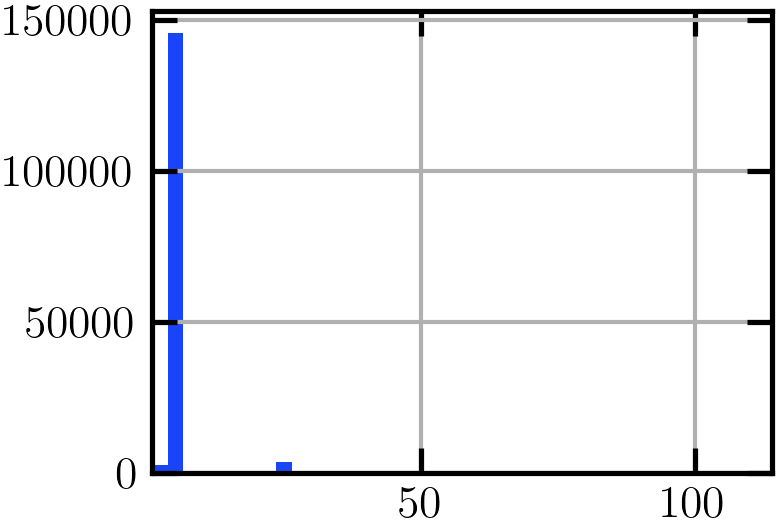

In [54]:
aggregated['smooth-or-featured_total-votes'].hist(bins=40)

Text(0, 0.5, 'Galaxies')

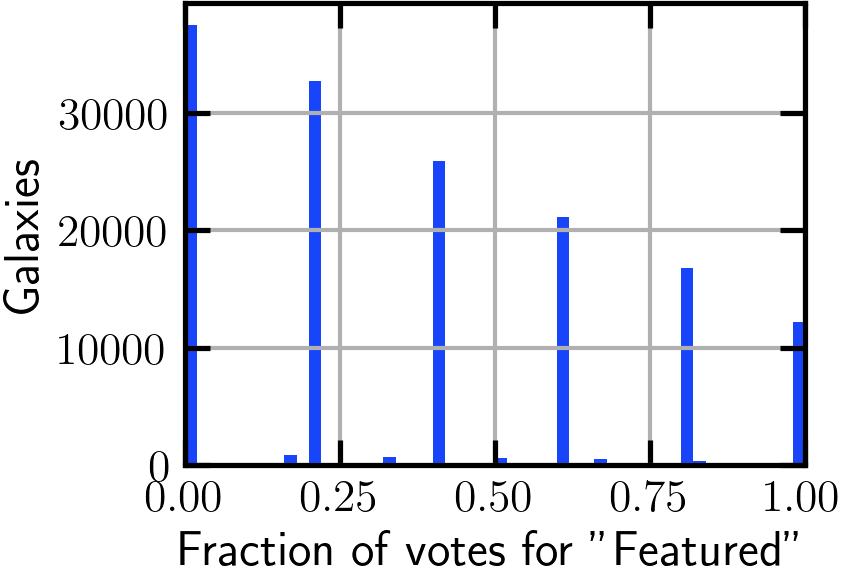

In [55]:
aggregated['smooth-or-featured_featured-or-disk_fraction'].hist(bins=50)
plt.xlabel('Fraction of votes for "Featured"')
plt.ylabel('Galaxies')

In [56]:
rare['value'].isna().sum()

0

In [57]:
rare['value'].value_counts()

value
[![no.png](https://panoptes-uploads.zooniverse.org/production/project_attached_image/096879e1-12ae-4df8-abb8-d4a93bc7797f.png =35x) Nothing Unusual]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [58]:
len(rare)

705947

In [59]:
rare

,task,task_label,value,id_str,user_id,classification_id,created_at,subject_ids,workflow_version
0,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
1,T10,Do you see any of these rare features?,[![irregular.png](https://panoptes-uploads.zoo...,98fe3b6effab15604e484d80ef47bb7a6cb310a2c12e11...,290475.0,575637443,2024-08-01 12:33:05+00:00,101101075,1.1
2,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,18b6d8c9f5df1c44366b2a3b5ff0b1d9b3e986dd01fb73...,2403423.0,575637955,2024-08-01 12:38:36+00:00,101093977,1.1
4,T10,Do you see any of these rare features?,[![overlapping.png](https://panoptes-uploads.z...,c52a8096a07e5a8af5339408267172ebcab0041a802d28...,NaN,575640326,2024-08-01 12:55:02+00:00,101086153,1.1
5,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,9cca18309a2cf193367e3f20830c7970b8b1a501b62d41...,NaN,575640565,2024-08-01 12:57:33+00:00,101091604,1.1
...,...,...,...,...,...,...,...,...,...
835085,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,ff4ef614a0916eb5cb6e8eb2018b40c5d52363b1c47b18...,927901.0,606747014,2024-12-21 01:30:09+00:00,101721378,1.1
835086,T10,Do you see any of these rare features?,[![irregular.png](https://panoptes-uploads.zoo...,e3e5d1084a84ff3cfb9ab51ae71d86dbec3e59dcd6f60f...,927901.0,606747229,2024-12-21 01:32:06+00:00,101721273,1.1
835087,T10,Do you see any of these rare features?,[![no.png](https://panoptes-uploads.zooniverse...,940e91343338bc2e71a2f19f397c548abb43d6bde99f46...,927901.0,606747286,2024-12-21 01:32:34+00:00,101735855,1.1
835088,T10,Do you see any of these rare features?,[![question_mark_manual.png](https://panoptes-...,9042f932c780da85e1f67a14f22eb14da71f877743e934...,927901.0,606747457,2024-12-21 01:33:52+00:00,101741965,1.1


In [60]:
# explode *again* to unpack the list in value
# rare.set_index('classification_id', inplace=True)
rare_exploded = rare.explode(['value'])  # df method preserves index
rare_exploded

,task,task_label,value,id_str,user_id,classification_id,created_at,subject_ids,workflow_version
0,T10,Do you see any of these rare features?,![no.png](https://panoptes-uploads.zooniverse....,bb9c2a3aab7b48ac9c21b7d6c781d062342ed8f2dd4145...,290475.0,575637319,2024-08-01 12:31:20+00:00,101103135,1.1
1,T10,Do you see any of these rare features?,![irregular.png](https://panoptes-uploads.zoon...,98fe3b6effab15604e484d80ef47bb7a6cb310a2c12e11...,290475.0,575637443,2024-08-01 12:33:05+00:00,101101075,1.1
2,T10,Do you see any of these rare features?,![no.png](https://panoptes-uploads.zooniverse....,18b6d8c9f5df1c44366b2a3b5ff0b1d9b3e986dd01fb73...,2403423.0,575637955,2024-08-01 12:38:36+00:00,101093977,1.1
4,T10,Do you see any of these rare features?,![overlapping.png](https://panoptes-uploads.zo...,c52a8096a07e5a8af5339408267172ebcab0041a802d28...,NaN,575640326,2024-08-01 12:55:02+00:00,101086153,1.1
5,T10,Do you see any of these rare features?,![no.png](https://panoptes-uploads.zooniverse....,9cca18309a2cf193367e3f20830c7970b8b1a501b62d41...,NaN,575640565,2024-08-01 12:57:33+00:00,101091604,1.1
...,...,...,...,...,...,...,...,...,...
835085,T10,Do you see any of these rare features?,![no.png](https://panoptes-uploads.zooniverse....,ff4ef614a0916eb5cb6e8eb2018b40c5d52363b1c47b18...,927901.0,606747014,2024-12-21 01:30:09+00:00,101721378,1.1
835086,T10,Do you see any of these rare features?,![irregular.png](https://panoptes-uploads.zoon...,e3e5d1084a84ff3cfb9ab51ae71d86dbec3e59dcd6f60f...,927901.0,606747229,2024-12-21 01:32:06+00:00,101721273,1.1
835087,T10,Do you see any of these rare features?,![no.png](https://panoptes-uploads.zooniverse....,940e91343338bc2e71a2f19f397c548abb43d6bde99f46...,927901.0,606747286,2024-12-21 01:32:34+00:00,101735855,1.1
835088,T10,Do you see any of these rare features?,![question_mark_manual.png](https://panoptes-u...,9042f932c780da85e1f67a14f22eb14da71f877743e934...,927901.0,606747457,2024-12-21 01:33:52+00:00,101741965,1.1


In [61]:
rare_exploded['value'] = rare_exploded['value'].apply(export_to_responses.sanitise_string)

In [62]:
rare_exploded['value'].value_counts()

value
nothing unusual    518339
something else      52079
overlapping         48945
irregular           43250
ring                36083
dust lane           27013
lens or arc         19501
Name: count, dtype: int64

In [63]:
rare_exploded['value'] = rare_exploded['value'].str.replace(' ', '_')

In [64]:
rare_pivoted = rare_exploded.pivot_table(index='id_str', columns='value', aggfunc='size', fill_value=0).reset_index()
rare_pivoted

value,id_str,dust_lane,irregular,lens_or_arc,nothing_unusual,overlapping,ring,something_else
0,000025c0749f53d1109ce125cc55d436ab993c64189836...,0,1,0,3,1,0,0
1,00004bc75b7f464e31bb5a9bbb348f3d453393a9b2f6cf...,0,0,0,1,0,0,0
2,0000a505e575fb99b9f1357a61eb7fa85a6358fba4e60f...,0,0,0,4,0,0,1
3,0001f34234e796b75e3c5ecc529d2d07ef0571a522e1ba...,1,0,0,2,1,0,0
4,0001f963f4eeff987b4605cca5eba4fdf717210f4a82ec...,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...
149556,fffd785f6c994848cf647e48b30abffc4dfc03927613c7...,1,1,1,4,0,1,0
149557,fffe5be14688312bb37c33083b5c558fab29e043a6cb1a...,0,0,0,5,0,0,0
149558,fffea0097b1f56d485fba0d9f82ca9b7518c50ac387986...,0,0,0,3,0,0,2
149559,ffff515b519b3e4cce85131e20d33aa955bfcda496c9b5...,0,0,0,5,0,0,0


In [65]:
rare_answers = rare_pivoted.columns[1:]
rare_answers

Index(['dust_lane', 'irregular', 'lens_or_arc', 'nothing_unusual',
       'overlapping', 'ring', 'something_else'],
      dtype='object', name='value')

In [66]:
rare_merged = pd.merge(aggregated, rare_pivoted, on='id_str', how='inner', validate='one_to_one')
rare_merged

,id_str,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_problem,how-rounded_round,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,artifact_other_fraction,artifact_ghost_fraction,subject_id,dust_lane,irregular,lens_or_arc,nothing_unusual,overlapping,ring,something_else
0,000025c0749f53d1109ce125cc55d436ab993c64189836...,2,3,0,0,2,0,0,3,0,...,0.0,0.0,101552209,0,1,0,3,1,0,0
1,00004bc75b7f464e31bb5a9bbb348f3d453393a9b2f6cf...,0,1,4,0,0,0,1,0,0,...,0.0,0.0,101564291,0,0,0,1,0,0,0
2,0000a505e575fb99b9f1357a61eb7fa85a6358fba4e60f...,3,2,0,2,1,0,0,2,0,...,0.0,0.0,101084770,0,0,0,4,0,0,1
3,0001f34234e796b75e3c5ecc529d2d07ef0571a522e1ba...,2,2,1,2,0,0,0,2,0,...,0.0,0.0,101672698,1,0,0,2,1,0,0
4,0001f963f4eeff987b4605cca5eba4fdf717210f4a82ec...,3,0,2,1,2,0,0,0,0,...,0.0,0.0,101561303,0,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149556,fffd785f6c994848cf647e48b30abffc4dfc03927613c7...,1,4,0,0,1,0,0,4,0,...,0.0,0.0,101547106,1,1,1,4,0,1,0
149557,fffe5be14688312bb37c33083b5c558fab29e043a6cb1a...,0,5,0,0,0,0,0,5,0,...,0.0,0.0,101084827,0,0,0,5,0,0,0
149558,fffea0097b1f56d485fba0d9f82ca9b7518c50ac387986...,0,5,0,0,0,0,0,5,0,...,0.0,0.0,101606321,0,0,0,3,0,0,2
149559,ffff515b519b3e4cce85131e20d33aa955bfcda496c9b5...,3,2,0,2,1,0,0,2,0,...,0.0,0.0,101117763,0,0,0,5,0,0,0


In [67]:
for col in rare_answers:
    rare_merged[col + '_fraction'] = rare_merged[col] / rare_merged['smooth-or-featured_total-votes']

In [68]:
rare_merged.to_csv(aggregated_loc.replace('.csv', '_with_rare.csv'), index=False)

In [69]:
rare_merged[rare_merged['smooth-or-featured_total-votes'] > 4].sort_values('lens_or_arc_fraction', ascending=False)

,id_str,smooth-or-featured_smooth,smooth-or-featured_featured-or-disk,smooth-or-featured_problem,how-rounded_round,how-rounded_in-between,how-rounded_cigar-shaped,disk-edge-on_yes,disk-edge-on_no,edge-on-bulge_rounded,...,overlapping,ring,something_else,dust_lane_fraction,irregular_fraction,lens_or_arc_fraction,nothing_unusual_fraction,overlapping_fraction,ring_fraction,something_else_fraction
116746,c81703daf68af627081f2443ed69928ad3c652a326795e...,3,2,0,3,0,0,1,1,1,...,1,0,0,0.0,0.2,1.0,0.0,0.2,0.0,0.0
81445,8b409b3c329015403d4d4ea6d7183d242d44460e0e29fd...,4,1,0,4,0,0,0,1,0,...,0,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.2
1900,034cb96e8be3130aeecdc5b1d3004e01f566cae2c2cc64...,5,0,0,2,3,0,0,0,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58629,649b1f2aac697507994e904645fee0c931974882736909...,3,2,0,3,0,0,0,2,0,...,0,1,1,0.0,0.0,1.0,0.0,0.0,0.2,0.2
8787,0f31905a7b748fe9810189905e7be28fe2bfa9316ea15a...,4,1,0,4,0,0,0,1,0,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52873,5ad457f9f08046070de3964849d2c7a6a2691debc98ab3...,4,0,1,3,1,0,0,0,0,...,0,0,0,0.0,0.0,0.0,0.8,0.0,0.0,0.0
52872,5ad401cd06ab0d5df16e27a7209364d74f7d821524954e...,3,1,1,0,3,0,0,1,0,...,0,0,1,0.0,0.0,0.0,0.6,0.0,0.0,0.2
52871,5ad3a7efdd701146264ac4392edd147bd8b43bbc6c163d...,1,4,0,1,0,0,0,4,0,...,1,0,2,0.0,0.0,0.0,0.4,0.2,0.0,0.4
52870,5ad342bf6e374f8a99c3196a74052dd44c24240d4d7ffa...,2,0,3,1,1,0,0,0,0,...,0,0,1,0.2,0.0,0.0,0.0,0.0,0.0,0.2


In [70]:
# tweak catalog to include renamed columns in format {question}-cd_{answer} expected by zoobot ortho schema

from zoobot.shared.schemas import euclid_ortho_schema

aggregated = pd.read_csv(aggregated_loc)

renamer = {}
for question in euclid_ortho_schema.questions:
  renamer[question.text.replace('-euclid', '') + '_total-votes'] = question.text + '_total-votes'
  for answer in question.answers:
    renamer[answer.text.replace('-euclid', '')] = answer.text
    renamer[answer.text.replace('-euclid', '') + '_fraction'] = answer.text + '_fraction'
# print(renamer)
aggregated = aggregated.rename(columns=renamer)

for label_col in euclid_ortho_schema.label_cols:
  assert label_col in aggregated.columns.values, 'Missing {}'.format(label_col)

aggregated.to_csv(aggregated_loc.replace('.csv', '_ortho.csv'), index=False)
